# Fashion MNIST 
- **Fashion MNIST dataset**: Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.
- **Goal**: classify grayscale Fashion-MNIST images into 10 classes
- **[Keras MNIST](https://keras.io/examples/vision/mnist_convnet/)**

In [82]:
# https://www.tensorflow.org/guide/keras/overview
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.14.0


In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [84]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_nums = len(class_names)
print(class_nums)

10


## 1. Load Data

In [85]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [86]:
!ls -l ~/.keras/datasets # data is download to keras's cache dir ~/.keras/datasets/

total 0
drwxr-xr-x  6 codexplore  staff  192 Jan 22 16:13 fashion-mnist


In [87]:
type(X_train), X_train.dtype, X_train.shape

(numpy.ndarray, dtype('uint8'), (60000, 28, 28))

-  Every image is represented as a (28 × 28) array &  the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). 

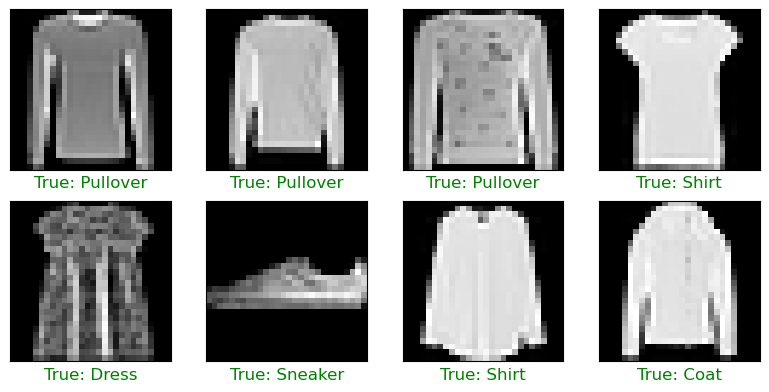

In [88]:
from typing import Optional
def plot_data(x_data: np.ndarray, y_data: np.ndarray, y_proba: Optional[np.ndarray]=None) -> None:
  nrows, ncols = 2, 4
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,4))
  len_x = x_data.shape[0]
  for idx in range(nrows*ncols):
    ax = axes[idx // ncols, idx % ncols]
    img_idx = random.randint(0, len_x)
    
    ax.imshow(x_data[img_idx], cmap='gray')
    
    ax.set(xticks=[], yticks=[])
    color = 'green'
    true_label_str = f"True: {class_names[y_data[img_idx]]}"
    if y_proba is not None: 
      predicted_idx = np.argmax(y_proba[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"
    
    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str
    
    ax.set_xlabel(img_title, color=color, fontsize=12)
  
  plt.tight_layout()
  plt.show()

plot_data(X_train, y_train)

## 2. Image Pre-processing
- Reshaping it into the shape the model expects and scaling it so that all values are in the `[0, 1]` interval
- Transform from `unit8` it into a `float32`

In [89]:
# Convert to float32 & Scale images to the [0, 1] range for training
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Make sure images have shape (60000, 28, 28) => (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [90]:
# convert class vectors to binary class matrices: 1 => [0 1 0 0 ...] 
# 1              => sparse_categorical_crossentropy
# [0 1 0 0 ...]  => categorical_crossentropy
y_train_label = keras.utils.to_categorical(y_train, class_nums)
y_test_label = keras.utils.to_categorical(y_test, class_nums)

In [91]:
print("y_train shape:", y_train_label.shape)

y_train shape: (60000, 10)


## 3. Network Architecture
- For  **binary classification** or multilabel binary classification, then we would use the `"sigmoid"` (i.e., logistic) activation function in the output layer instead of the `"softmax"` activation function, and we would use the `"binary_crossentropy"` loss.
- Loss function:
  - `"sparse_categorical_crossentropy"` loss because we have sparse labels: (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 
  - `"categorical_crossentropy"`: If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. 

- `tf.keras.backend.clear_session()` to reset name_counters by clearing all global state managed by Keras is stored in a Keras session
- `tf.keras.utils.set_random_seed()` function, which conveniently sets the random seeds for **TensorFlow**, **Python** (`random.seed()`), and **NumPy** (`np.random.seed()`)
- **First Layer** (`input_shape`): only the shape of the instances, doesn’t include the batch size
- **Flatten Layer**: convert each input image into a 1D array: 
    - For example, if it receives a batch of shape `[32, 28, 28]`, it will reshape it to `[32, 784]`. 
- **Dense Hidden Layer** with 300 neurons:
    - Input layer has 784 nodes, total trainable parameters in this dense layer 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters

In [110]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For model, we can use:
- `.layers` attribute: to get a model’s list of layers
- `.get_layer()` method to access a layer by name

In [94]:
# get a model’s list of layers 
model.layers

In [95]:
hidden_1 = model.layers[1] # named as 'dense'
print(hidden_1.name)
print(model.get_layer('dense') is hidden_1) # tru

dense
True


For each layer, we can use
- `.get_weights()` to access all the parameters of a layer
- `.set_weights()` to init & set the parameters of a layer
- If you want to use a different initialization method, you can set `kernel_initializer` (kernel is another name for the matrix of connection weights) or `bias_initializer` when creating the layer.
    - Full list: [Kernel Initializer](https://keras.io/api/layers/initializers)

In [96]:
# For a Dense layer, this includes both the connection weights and the bias terms
weights, biases = hidden_1.get_weights()
print(weights.shape)
print(biases.shape)

(784, 256)
(256,)


### Model Compilation
- Full lists: [Losses](https://keras.io/api/losses), [Optimizer](https://keras.io/api/optimizers), and [Metrics](https://keras.io/api/metrics)

In [111]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01)
# optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
"""
## Train the model


epochs = 30
batch_size = 128
history = model.fit(X_train, 
                    y_train_label, 
                    epochs=epochs, 
                    batch_size=batch_size, # defaults to 32
                    validation_split=0.1,  # use the last 10% of the data (before shuffling) for validation
                    )
"""

'\n## Train the model\n\n\nepochs = 30\nbatch_size = 128\nhistory = model.fit(X_train, \n                    y_train_label, \n                    epochs=epochs, \n                    batch_size=batch_size, # defaults to 32\n                    validation_split=0.1,  # use the last 10% of the data (before shuffling) for validation\n                    )\n'

In [ ]:
# pd.DataFrame(history.history).plot(
#     figsize=(15, 5), xlim=[0, epochs-1], ylim=[0, 1], grid=True, xlabel="Epoch",
#     style=["r--", "r--.", "b-", "b-*"])
# plt.show()

### Save Model

- Set `save_format="tf"`, Keras saves the model using TensorFlow’s **SavedModel** format
    - `saved_model.pb` file contains the model’s architecture and logic in the form of a serialized computation graph, so you don’t need to deploy the model’s source code in order to use it in production
    - `keras_metadata.pb` file contains extra information needed by Keras.
    - `variables` directory contains all the parameter values (including the connection weights, the biases, the normalization statistics, and the optimizer’s parameters), 
        - possibly split across multiple files if the model is very large. 
    - `assets` directory may contain extra files, such as data samples, feature names, class names, and so on. By default, the assets directory is empty. 
        - Since the optimizer is also saved, including its hyperparameters and any state it may have, after loading the model you can continue training if you want.
- Set `save_format="h5"` or use a filename that ends with .h5, .hdf5, or .keras, then Keras will save the model to a single file using a Keras-specific format based on the HDF5 format. However, most TensorFlow deployment tools require the SavedModel format instead.
- Use `save_weights()` and `load_weights()` to save and load only the parameter values.
    -  This includes the connection weights, biases, preprocessing stats, optimizer state, etc. 
    - The parameter values are saved in one or more files such as` my_weights.data-00004-of-00052`, plus an index file like `my_weights.index`.
    - Saving just the weights is faster and uses less disk space than saving the whole model, so it’s perfect to save quick **checkpoints** during training. 



In [ ]:
# model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


### Use Callbacks
- `ModelCheckpoint` callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch
- `EarlyStopping` callback will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the `patience` argument)
- Other [Callbacks](https://keras.io/api/callbacks/)

In [107]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_ckhp/my_checkpoints",
                                                   save_weights_only=True,
                                                   save_best_only=True, # only save your model when its performance on the validation set is the best so far.
                                                   )
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

In [113]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                # profile_batch=(100, 200)
                                            )

#### Custom Callbacks
- You can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting)
- You can implement the custom call backs:
    - During training: `on_train_begin(`), `on_train_end()`, `on_epoch_begin()`, `on_epoch_end(`), `on_batch_begin()`, and `on_batch_end()`
    - During evaluation which is called by `evaluate`: `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, `or on_test_batch_end()`
    - During prediction which is called by `predict`: `on_predict_begin()`, `on_predict_end()`, `on_predict_batch_begin()`, or `on_predict_batch_end()`

In [103]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f" val/train={ratio:.2f}")

val_train_ratio_cb = PrintValTrainRatioCallback()

In [114]:
epochs = 30
batch_size = 32
history = model.fit(X_train, 
                    y_train_label, 
                    epochs=epochs, 
                    batch_size=batch_size, # defaults to 32
                    validation_split=0.1,  # use the last 10% of the data (before shuffling) for validation
                    callbacks=[
                        checkpoint_cb, early_stopping_cb, 
                        val_train_ratio_cb, tensorboard_cb
                    ]
                )

Epoch 1/30
1688/1688 [==============================] - 16s 9ms/step - loss: 0.7187 - accuracy: 0.7566 - val_loss: 0.5503 - val_accuracy: 0.8088
Epoch 2/30
1688/1688 [==============================] - 15s 9ms/step - loss: 0.5138 - accuracy: 0.8235 - val_loss: 0.5029 - val_accuracy: 0.8263
Epoch 3/30
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4794 - accuracy: 0.8346 - val_loss: 0.4904 - val_accuracy: 0.8293
Epoch 4/30
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4600 - accuracy: 0.8415 - val_loss: 0.4649 - val_accuracy: 0.8310
Epoch 5/30
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4498 - accuracy: 0.8441 - val_loss: 0.4627 - val_accuracy: 0.8360
Epoch 6/30
1688/1688 [==============================] - 15s 9ms/step - loss: 0.4426 - accuracy: 0.8471 - val_loss: 0.4496 - val_accuracy: 0.8365
Epoch 7/30
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4381 - accuracy: 0.8475 - val_loss: 0.4457 - val_ac

# 4. Model Evaluation

In [ ]:
"""
## Evaluate the trained model
"""

score = model.evaluate(X_test, y_test_label, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.4589828550815582
Test accuracy: 0.8393999934196472


# 5. Prediction

In [ ]:
X_sample = X_test[:3]
y_proba = model.predict(X_sample)
pd.DataFrame([[*y_p, class_names[y_l]] for y_p, y_l in zip(y_proba.round(3), y_test[:3])], 
              columns=[*class_names, 'Label'])


1/1 [==============================] - 0s 45ms/step


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot,Label
0,0.0,0.0,0.000,0.0,0.000,0.125,0.000,0.089,0.002,0.784,Ankle boot
1,0.0,0.0,0.946,0.0,0.012,0.000,0.042,0.000,0.000,0.000,Pullover
2,0.0,1.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,Trouser


In [ ]:
predictions = np.argmax(y_proba, axis=1)
print([class_names[pred_idx] for pred_idx in predictions])

['Ankle boot', 'Pullover', 'Trouser']


In [ ]:
y_proba = model.predict(X_test)

  1/313 [..............................] - ETA: 4s

313/313 [==============================] - 0s 2ms/step


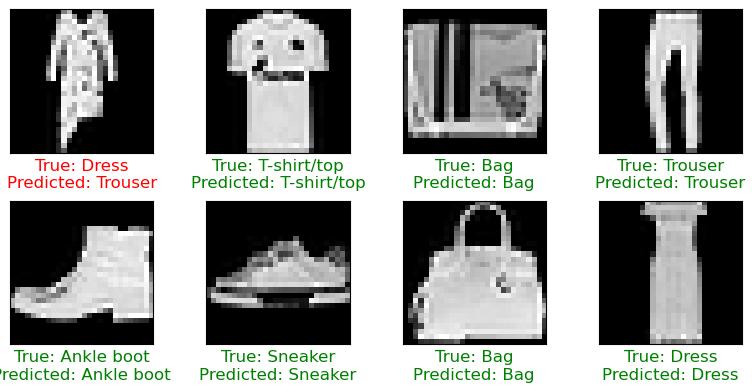

In [ ]:
plot_data(X_test, y_test, y_proba)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.argmax(y_proba, axis=1), target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.83      0.78      0.80      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.70      0.79      0.74      1000
       Dress       0.81      0.87      0.84      1000
        Coat       0.75      0.72      0.73      1000
      Sandal       0.94      0.91      0.92      1000
       Shirt       0.62      0.57      0.59      1000
     Sneaker       0.91      0.92      0.92      1000
         Bag       0.94      0.94      0.94      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

